In [56]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [57]:
#CSV import for crashes table
filepath = "Datasets/crash_records_ml.csv"
df = pd.read_csv(filepath)
df.head()

,Make,Model,Model Year,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Roadway Description,Posted Speed Limit (MPH),Lighting,Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted
0,Jaguar,I-Pace,2021,January 2024,12:04,Los Angeles,CA,Street,Dry,No Unusual Conditions,25.0,Daylight,1,0,0,0,0,0,1,0
1,Jaguar,I-Pace,2024,July 2024,04:58,San Francisco,CA,Street,Dry,No Unusual Conditions,25.0,Dark - Lighted,1,0,0,0,0,0,0,0
2,Jaguar,I-Pace,2024,July 2024,11:29,Phoenix,AZ,Parking Lot,Dry,No Unusual Conditions,5.0,Daylight,1,0,0,0,0,0,0,1
3,Jaguar,I-Pace,2024,July 2024,18:16,San Francisco,CA,Street,Dry,No Unusual Conditions,25.0,Daylight,1,0,0,0,0,0,0,0
4,Jaguar,I-Pace,2024,July 2024,11:06,Austin,TX,Street,Dry,No Unusual Conditions,40.0,Daylight,0,0,1,0,0,0,0,1


In [58]:
df = df.dropna()

In [59]:
df.columns

Index(['Make', 'Model', 'Model Year', 'Incident Date', 'Incident Time (24:00)',
       'City', 'State', 'Roadway Type', 'Roadway Surface',
       'Roadway Description', 'Posted Speed Limit (MPH)', 'Lighting', 'Clear',
       'Snow', 'Cloudy', 'Fog/Smoke', 'Rain', 'Severe Wind', 'Injuries',
       'Passengers Belted'],
      dtype='object')

In [60]:
cols_to_drop= ['City', 'State','Make','Model', 'Incident Date','Roadway Description','Incident Date','Lighting']
df_ml = df.drop(cols_to_drop, axis=1)
df_ml.head()

,Model Year,Incident Time (24:00),Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted
0,2021,12:04,Street,Dry,25.0,1,0,0,0,0,0,1,0
1,2024,04:58,Street,Dry,25.0,1,0,0,0,0,0,0,0
2,2024,11:29,Parking Lot,Dry,5.0,1,0,0,0,0,0,0,1
3,2024,18:16,Street,Dry,25.0,1,0,0,0,0,0,0,0
4,2024,11:06,Street,Dry,40.0,0,0,1,0,0,0,0,1


In [61]:
#  Dropping the columns with no positive results for the period that was covered by this report.
#  May need to re-instate as more incidents come up
cols_to_drop= ['Severe Wind', 'Fog/Smoke']
df_ml = df_ml.drop(cols_to_drop, axis=1)
df_ml.head()

,Model Year,Incident Time (24:00),Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Clear,Snow,Cloudy,Rain,Injuries,Passengers Belted
0,2021,12:04,Street,Dry,25.0,1,0,0,0,1,0
1,2024,04:58,Street,Dry,25.0,1,0,0,0,0,0
2,2024,11:29,Parking Lot,Dry,5.0,1,0,0,0,0,1
3,2024,18:16,Street,Dry,25.0,1,0,0,0,0,0
4,2024,11:06,Street,Dry,40.0,0,0,1,0,0,1


In [62]:
# df_ml.loc[df_ml['Weather - Clear'] == 'Y', 'Weather - Clear'] = 'Clear'
# df_ml.loc[df_ml['Weather - Snow'] == 'Y', 'Weather - Snow'] = 'Snow'
# df_ml.loc[df_ml['Weather - Cloudy'] == 'Y', 'Weather - Cloudy'] = 'Cloudy'
# df_ml.loc[df_ml['Weather - Rain'] == 'Y', 'Weather - Rain'] = 'Rain'
# df_ml['Weather'] = df_ml[['Weather - Clear', 'Weather - Snow', 'Weather - Cloudy', 'Weather - Rain']].agg(' '.join, axis=1)
# df_ml.loc[df_ml['Weather'] == '           ', 'Weather'] = 'Clear'
# df_ml['Weather'] = df_ml['Weather'].str.strip()
# df_ml.loc[df_ml['Weather'] == 'Clear   Cloudy', 'Weather'] = 'Clear'
# df_ml.loc[df_ml['Weather'] == 'Cloudy   Rain', 'Weather'] = 'Rain'
# df_ml.loc[df_ml['Weather'] == '            ', 'Weather'] = 'Clear'
# df_ml['Weather'].fillna("Clear", inplace=True)
# df_ml['Weather'] = df_ml['Weather'].str.strip()
# df_ml.head()

In [63]:
def categorize_time(incident_time): #X-pert advised
    if isinstance(incident_time, str):
        if "00:00" <= incident_time < "10:00":
            return "Morning"
        elif "10:00" <= incident_time <= "16:00":
            return "Afternoon"
        else:
            return "Night"
    else:
        return None  # or return a default value, e.g., "Unknown"

# Apply the function to the Incident Time column
df_ml['Incident Time (24:00)'] = df_ml['Incident Time (24:00)'].apply(categorize_time)

In [64]:
df_ml['Incident Time (24:00)'].value_counts()

Incident Time (24:00)
Night        472
Afternoon    451
Morning      405
Name: count, dtype: int64

In [65]:
df_ml = df_ml.rename(columns = {'Incident Time (24:00)': "Time of Day"})
df_ml['Time of Day'].value_counts()

Time of Day
Night        472
Afternoon    451
Morning      405
Name: count, dtype: int64

In [66]:
df_ml = df_ml.rename(columns = {'Posted Speed Limit (MPH)': "Speed Limit"})
df_ml['Speed Limit'] = df_ml['Speed Limit'].astype(int)


In [67]:
bins = [-float('inf'), 20, 40, 60, 80, float('inf')]
labels = ['<=20', '20-40', '40-60', '60-80', '>80']
df_ml['Speed Category'] = pd.cut(df_ml['Speed Limit'], bins=bins, labels=labels)
df_ml.head()

,Model Year,Time of Day,Roadway Type,Roadway Surface,Speed Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers Belted,Speed Category
0,2021,Afternoon,Street,Dry,25,1,0,0,0,1,0,20-40
1,2024,Morning,Street,Dry,25,1,0,0,0,0,0,20-40
2,2024,Afternoon,Parking Lot,Dry,5,1,0,0,0,0,1,<=20
3,2024,Night,Street,Dry,25,1,0,0,0,0,0,20-40
4,2024,Afternoon,Street,Dry,40,0,0,1,0,0,1,20-40


In [68]:
df_ml.columns

Index(['Model Year', 'Time of Day', 'Roadway Type', 'Roadway Surface',
       'Speed Limit', 'Clear', 'Snow', 'Cloudy', 'Rain', 'Injuries',
       'Passengers Belted', 'Speed Category'],
      dtype='object')

In [69]:
df_ml['Roadway Type'] = df_ml['Roadway Type'].replace({
    'Unknown': 'Other',
    'Traffic Circle': 'Other',
    'Parking Lot': 'Other',
    'Highway / Freeway': 'Highway'
})

In [70]:
df_ml['Roadway Type'].value_counts()

Roadway Type
Intersection    590
Street          571
Highway          99
Other            68
Name: count, dtype: int64

In [71]:
df_ml['Roadway Surface'] = df_ml['Roadway Surface'].replace({
    'Unknown': 'Wet',
    'Snow / Slush / Ice': 'Wet'
})

In [72]:
df_ml['Roadway Surface'].value_counts()

Roadway Surface
Dry    1261
Wet      67
Name: count, dtype: int64

In [73]:
df_ml['Model Year'].value_counts()

Model Year
2021    558
2023    268
2020    134
2022    118
2024     96
2017     48
2016     46
2019     44
9999      8
2018      8
Name: count, dtype: int64

In [74]:
df_ml['Speed Limit'].value_counts()

Speed Limit
25    751
30    147
35    110
45     58
15     54
65     53
20     45
40     40
75     30
5      13
10      5
55      5
0       4
70      4
60      4
9       3
50      1
1       1
Name: count, dtype: int64

In [75]:
df_ml['Speed Category'].value_counts()

Speed Category
20-40    1048
<=20      125
60-80      87
40-60      68
>80         0
Name: count, dtype: int64

In [76]:
df_ml.head()

,Model Year,Time of Day,Roadway Type,Roadway Surface,Speed Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers Belted,Speed Category
0,2021,Afternoon,Street,Dry,25,1,0,0,0,1,0,20-40
1,2024,Morning,Street,Dry,25,1,0,0,0,0,0,20-40
2,2024,Afternoon,Other,Dry,5,1,0,0,0,0,1,<=20
3,2024,Night,Street,Dry,25,1,0,0,0,0,0,20-40
4,2024,Afternoon,Street,Dry,40,0,0,1,0,0,1,20-40


In [77]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1328 entries, 0 to 1361
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Model Year         1328 non-null   int64   
 1   Time of Day        1328 non-null   object  
 2   Roadway Type       1328 non-null   object  
 3   Roadway Surface    1328 non-null   object  
 4   Speed Limit        1328 non-null   int32   
 5   Clear              1328 non-null   int64   
 6   Snow               1328 non-null   int64   
 7   Cloudy             1328 non-null   int64   
 8   Rain               1328 non-null   int64   
 9   Injuries           1328 non-null   int64   
 10  Passengers Belted  1328 non-null   int64   
 11  Speed Category     1328 non-null   category
dtypes: category(1), int32(1), int64(7), object(3)
memory usage: 120.8+ KB


In [78]:
df_ml.describe()

,Model Year,Speed Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers Belted
count,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000
mean,2069.266566,29.847892,0.827560,0.000753,0.128012,0.033133,0.197289,0.648343
std,617.564092,12.588295,0.377905,0.027441,0.334229,0.179050,0.398102,0.477667
min,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021.000000,25.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2021.000000,25.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2023.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9999.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [79]:
features = ['Model Year', 'Time of Day', 'Roadway Type', 'Roadway Surface',
        'Clear', 'Snow', 'Cloudy', 'Rain', 'Passengers Belted','Speed Category']
#'Speed Limit',

# We are looking to see if Injuries are resultant from various characteristics, as a result "Injuries" was dropped from the features as it'll be against our test case.

In [80]:
df_ml.columns

Index(['Model Year', 'Time of Day', 'Roadway Type', 'Roadway Surface',
       'Speed Limit', 'Clear', 'Snow', 'Cloudy', 'Rain', 'Injuries',
       'Passengers Belted', 'Speed Category'],
      dtype='object')

In [81]:
## Need  to do a classificiation model

# Define Preprocessing Pipelines

# Define preprocessing for numeric features (Age, Fare, Family_Size) (note that for age, we just use the column median, not split by gender)
#, 'Speed Limit'
numeric_features = ['Model Year'] # You can also do this in a loop, select the numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])
    # ('scaler', StandardScaler())])

# # Define preprocessing for the binary features ('CryoSleep', 'VIP', 'Side')
binary_features = ['Clear', 'Snow', 'Cloudy', 'Rain', 'Passengers Belted']
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('label', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])  # Label encode for binary feature

# # Define preprocessing for categorical features ('HomePlanet', 'Destination', 'Deck') 
#, 'Speed Category'
categorical_features = ['Time of Day', 'Roadway Type', 'Roadway Surface', 'Speed Category']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# # Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('binary', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)])

In [82]:
# Use only preprocessing pipeline to transform the data
preprocessed_X_train = preprocessor.fit_transform(df_ml)

# Convert preprocessed data to a DataFrame
# Get the feature names after one-hot encoding
encoded_feature_names = (numeric_features + binary_features +
                         list(preprocessor.transformers_[2][1]['onehot'].get_feature_names_out(categorical_features)))

df_final = pd.DataFrame(preprocessed_X_train, columns=encoded_feature_names)
df_final["Injuries"] = df_ml.Injuries
df_final.head()

,Model Year,Clear,Snow,Cloudy,Rain,Passengers Belted,Time of Day_Afternoon,Time of Day_Morning,Time of Day_Night,Roadway Type_Highway,Roadway Type_Intersection,Roadway Type_Other,Roadway Type_Street,Roadway Surface_Dry,Roadway Surface_Wet,Speed Category_20-40,Speed Category_40-60,Speed Category_60-80,Speed Category_<=20,Injuries
0,2021.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2024.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2024.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2024.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2024.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [83]:
corrs = df_final.corr()
corrs

,Model Year,Clear,Snow,Cloudy,Rain,Passengers Belted,Time of Day_Afternoon,Time of Day_Morning,Time of Day_Night,Roadway Type_Highway,Roadway Type_Intersection,Roadway Type_Other,Roadway Type_Street,Roadway Surface_Dry,Roadway Surface_Wet,Speed Category_20-40,Speed Category_40-60,Speed Category_60-80,Speed Category_<=20,Injuries
Model Year,1.000000,0.009522,-0.002102,-0.000476,-0.014296,-0.004817,0.046315,-0.008913,-0.037253,-0.021814,-0.030424,0.114305,-0.008782,0.017844,-0.017844,-0.031307,-0.018562,-0.020342,0.074981,0.010375
Clear,0.009522,1.000000,-0.060138,-0.833400,-0.405532,-0.077354,-0.059895,0.003629,0.055771,-0.189184,0.079189,0.024652,0.009917,0.459428,-0.459428,0.081691,-0.002479,-0.144995,0.010615,-0.002492
Snow,-0.002102,-0.060138,1.000000,-0.010518,-0.005082,0.020217,0.038280,-0.018184,-0.020384,-0.007791,-0.024545,-0.006377,0.031608,-0.119093,0.119093,0.014189,-0.006377,-0.007268,-0.008849,0.055999
Cloudy,-0.000476,-0.833400,-0.010518,1.000000,-0.020558,0.083933,0.115489,-0.053090,-0.063200,0.217323,-0.047750,-0.037883,-0.050510,-0.107331,0.107331,-0.078220,0.023469,0.162715,-0.046322,0.012526
Rain,-0.014296,-0.405532,-0.005082,-0.020558,1.000000,-0.031078,-0.035027,0.051003,-0.014403,0.011531,-0.055444,-0.043004,0.068676,-0.803090,0.803090,-0.028084,-0.004829,0.019001,0.026776,-0.050359
Passengers Belted,-0.004817,-0.077354,0.020217,0.083933,-0.031078,1.000000,0.201791,-0.186954,-0.019828,0.209025,0.071340,-0.057863,-0.156738,0.003163,-0.003163,-0.102313,0.099542,0.194998,-0.097444,0.043819
Time of Day_Afternoon,0.046315,-0.059895,0.038280,0.115489,-0.035027,0.201791,1.000000,-0.475024,-0.532504,0.111258,-0.071582,0.064252,-0.015790,0.041799,-0.041799,-0.147775,0.107535,0.073608,0.062888,-0.009191
Time of Day_Morning,-0.008913,0.003629,-0.018184,-0.053090,0.051003,-0.186954,-0.475024,1.000000,-0.491882,-0.057238,0.056181,-0.005476,-0.023581,-0.026655,0.026655,0.089783,-0.049999,-0.036571,-0.056691,0.004437
Time of Day_Night,-0.037253,0.055771,-0.020384,-0.063200,-0.014403,-0.019828,-0.532504,-0.491882,1.000000,-0.055025,0.016785,-0.058304,0.038306,-0.015718,0.015718,0.059851,-0.058304,-0.037652,-0.007692,0.004838
Roadway Type_Highway,-0.021814,-0.189184,-0.007791,0.217323,0.011531,0.209025,0.111258,-0.057238,-0.055025,1.000000,-0.253770,-0.065934,-0.246497,0.013029,-0.013029,-0.549090,0.090145,0.932894,-0.091488,0.020700


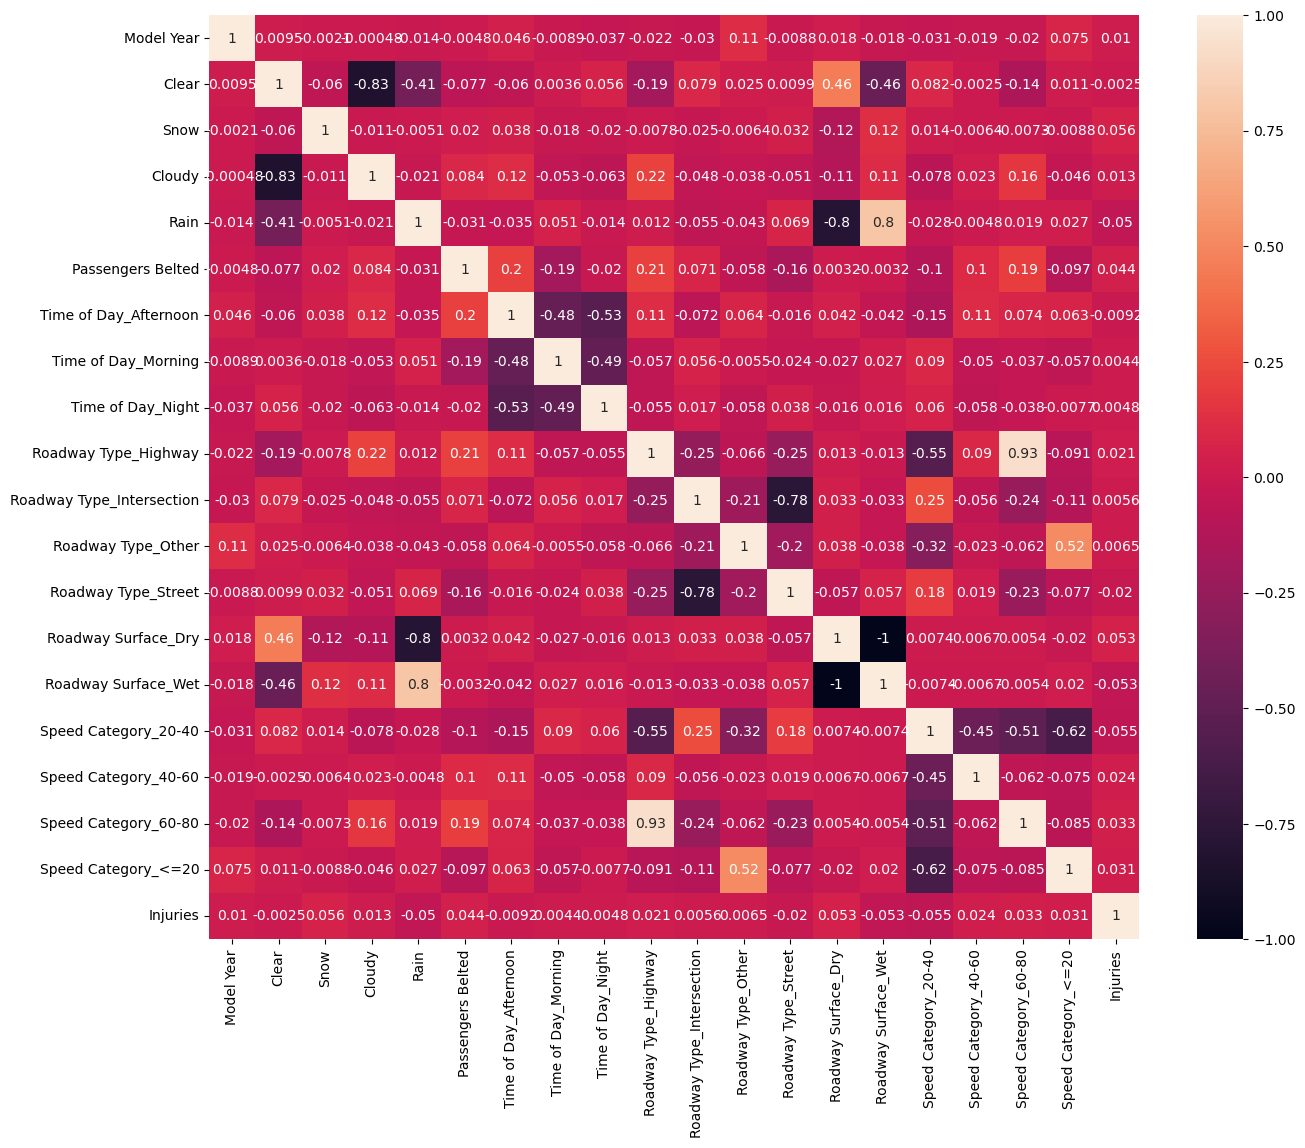

In [84]:
plt.figure(figsize=(15,12))
sns.heatmap(corrs, annot=True)
plt.show()

In [85]:
abs(corrs.Injuries).sort_values(ascending=False)

Injuries                     1.000000
Snow                         0.055999
Speed Category_20-40         0.054984
Roadway Surface_Dry          0.053409
Roadway Surface_Wet          0.053409
Rain                         0.050359
Passengers Belted            0.043819
Speed Category_60-80         0.032762
Speed Category_<=20          0.030863
Speed Category_40-60         0.024032
Roadway Type_Highway         0.020700
Roadway Type_Street          0.019582
Cloudy                       0.012526
Model Year                   0.010375
Time of Day_Afternoon        0.009191
Roadway Type_Other           0.006522
Roadway Type_Intersection    0.005631
Time of Day_Night            0.004838
Time of Day_Morning          0.004437
Clear                        0.002492
Name: Injuries, dtype: float64

In [86]:
X = df_ml.drop(columns=["Injuries"])
y = df_ml.Injuries

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y) # stratify=True maintains target class percentages
print(X_train.shape, X_test.shape)

(996, 11) (332, 11)


In [87]:
X_train.head()

,Model Year,Time of Day,Roadway Type,Roadway Surface,Speed Limit,Clear,Snow,Cloudy,Rain,Passengers Belted,Speed Category
66,2024,Afternoon,Street,Dry,25,1,0,0,0,0,20-40
1191,2021,Night,Intersection,Dry,25,1,0,0,0,1,20-40
1221,2021,Afternoon,Street,Dry,25,1,0,0,0,1,20-40
536,2021,Afternoon,Intersection,Dry,25,1,0,0,0,1,20-40
765,2023,Morning,Intersection,Dry,25,1,0,0,0,0,20-40


In [88]:
def doClassification(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)
    
    train_results = f"""TRAIN METRICS
    Confusion Matrix: 
    {train_cf}
    
    AUC: {train_auc}

    Classification Report:
    {train_cr}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)
    
    test_results = f"""TEST METRICS
    Confusion Matrix: 
    {test_cf}
    
    AUC: {test_auc}

    Classification Report:
    {test_cr}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    
    # Set figure size
    plt.figure(figsize=(6, 6))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

TRAIN METRICS
    Confusion Matrix: 
    [[789  11]
 [183  13]]
    
    AUC: 0.6441964285714286

    Classification Report:
                  precision    recall  f1-score   support

           0       0.81      0.99      0.89       800
           1       0.54      0.07      0.12       196

    accuracy                           0.81       996
   macro avg       0.68      0.53      0.50       996
weighted avg       0.76      0.81      0.74       996

    
TEST METRICS
    Confusion Matrix: 
    [[258   8]
 [ 65   1]]
    
    AUC: 0.6310947824105719

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      0.97      0.88       266
           1       0.11      0.02      0.03        66

    accuracy                           0.78       332
   macro avg       0.45      0.49      0.45       332
weighted avg       0.66      0.78      0.71       332

    


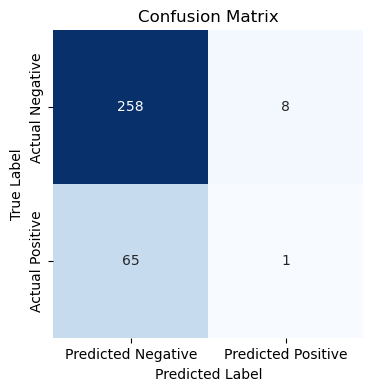

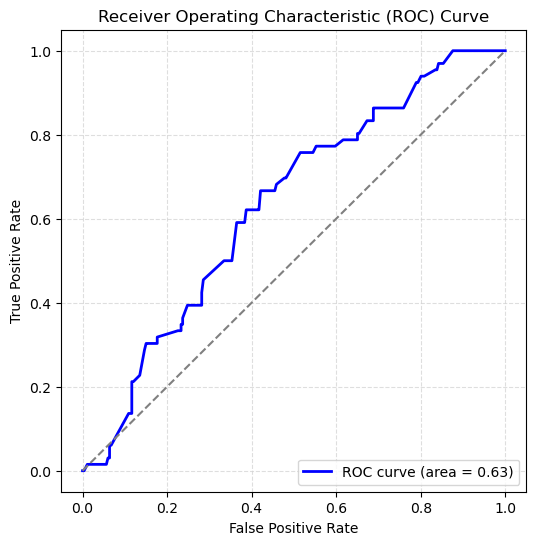

In [89]:
# Step 2: Init the Model
lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Do Machine Learning
doClassification(lr, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[780  20]
 [101  95]]
    
    AUC: 0.9048022959183674

    Classification Report:
                  precision    recall  f1-score   support

           0       0.89      0.97      0.93       800
           1       0.83      0.48      0.61       196

    accuracy                           0.88       996
   macro avg       0.86      0.73      0.77       996
weighted avg       0.87      0.88      0.87       996

    
TEST METRICS
    Confusion Matrix: 
    [[241  25]
 [ 39  27]]
    
    AUC: 0.7992993848257006

    Classification Report:
                  precision    recall  f1-score   support

           0       0.86      0.91      0.88       266
           1       0.52      0.41      0.46        66

    accuracy                           0.81       332
   macro avg       0.69      0.66      0.67       332
weighted avg       0.79      0.81      0.80       332

    


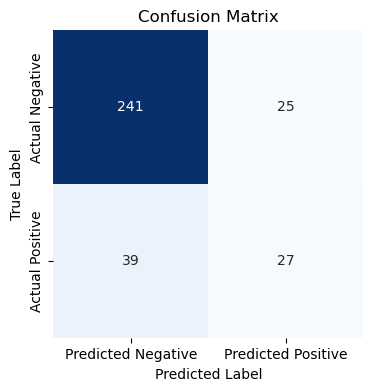

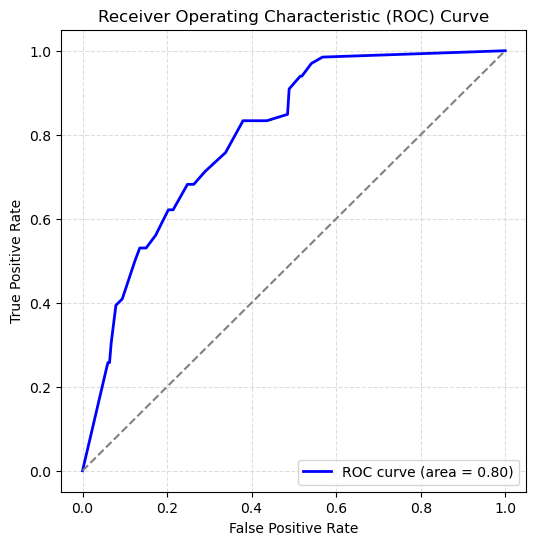

In [90]:
dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Do Machine Learning
doClassification(dt, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[776  24]
 [ 97  99]]
    
    AUC: 0.9015561224489795

    Classification Report:
                  precision    recall  f1-score   support

           0       0.89      0.97      0.93       800
           1       0.80      0.51      0.62       196

    accuracy                           0.88       996
   macro avg       0.85      0.74      0.77       996
weighted avg       0.87      0.88      0.87       996

    
TEST METRICS
    Confusion Matrix: 
    [[238  28]
 [ 35  31]]
    
    AUC: 0.7992424242424242

    Classification Report:
                  precision    recall  f1-score   support

           0       0.87      0.89      0.88       266
           1       0.53      0.47      0.50        66

    accuracy                           0.81       332
   macro avg       0.70      0.68      0.69       332
weighted avg       0.80      0.81      0.81       332

    


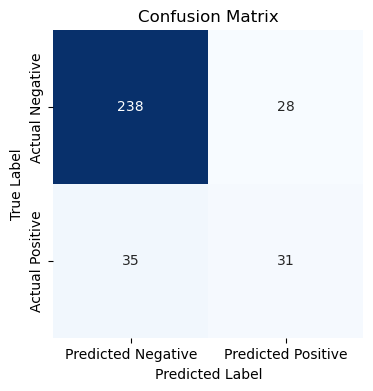

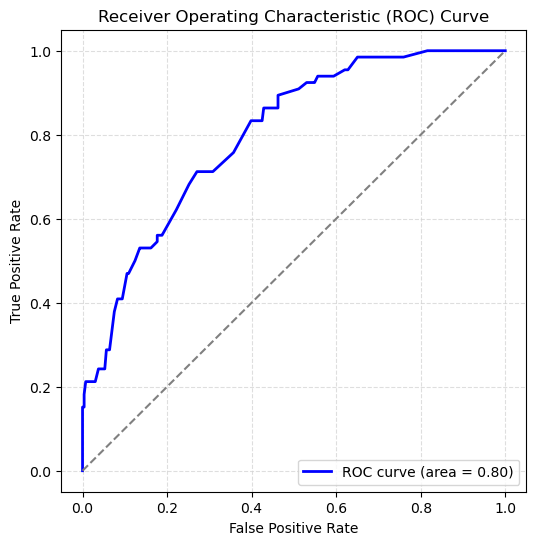

In [91]:
# Step 2: Init the Model
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Do Machine Learning
doClassification(rf, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[800   0]
 [196   0]]
    
    AUC: 0.5699426020408164

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      1.00      0.89       800
           1       0.00      0.00      0.00       196

    accuracy                           0.80       996
   macro avg       0.40      0.50      0.45       996
weighted avg       0.65      0.80      0.72       996

    
TEST METRICS
    Confusion Matrix: 
    [[266   0]
 [ 66   0]]
    
    AUC: 0.5034461152882206

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      1.00      0.89       266
           1       0.00      0.00      0.00        66

    accuracy                           0.80       332
   macro avg       0.40      0.50      0.44       332
weighted avg       0.64      0.80      0.71       332

    


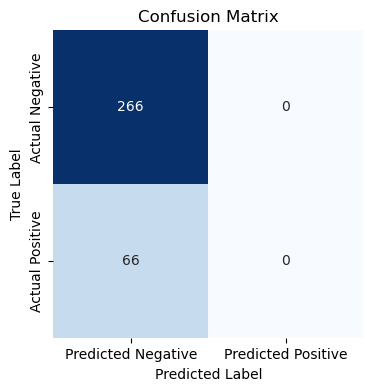

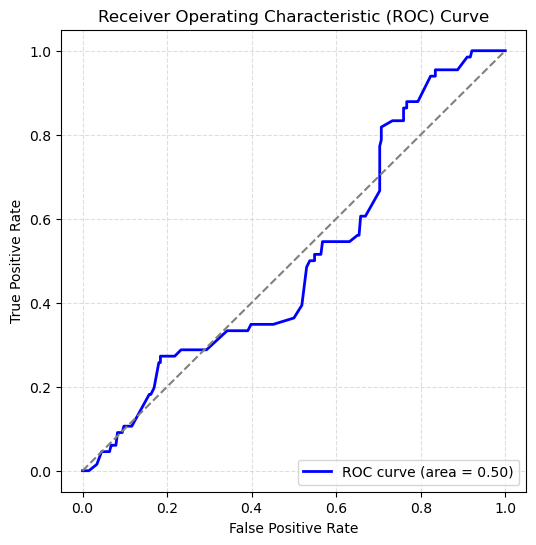

In [92]:
# Step 2: Init the Model
svc = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

# Do Machine Learning
doClassification(svc, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[790  10]
 [175  21]]
    
    AUC: 0.733501275510204

    Classification Report:
                  precision    recall  f1-score   support

           0       0.82      0.99      0.90       800
           1       0.68      0.11      0.19       196

    accuracy                           0.81       996
   macro avg       0.75      0.55      0.54       996
weighted avg       0.79      0.81      0.76       996

    
TEST METRICS
    Confusion Matrix: 
    [[261   5]
 [ 59   7]]
    
    AUC: 0.6556732740943267

    Classification Report:
                  precision    recall  f1-score   support

           0       0.82      0.98      0.89       266
           1       0.58      0.11      0.18        66

    accuracy                           0.81       332
   macro avg       0.70      0.54      0.54       332
weighted avg       0.77      0.81      0.75       332

    


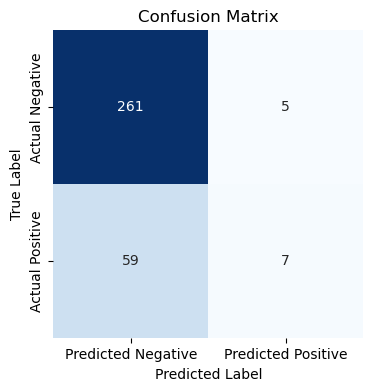

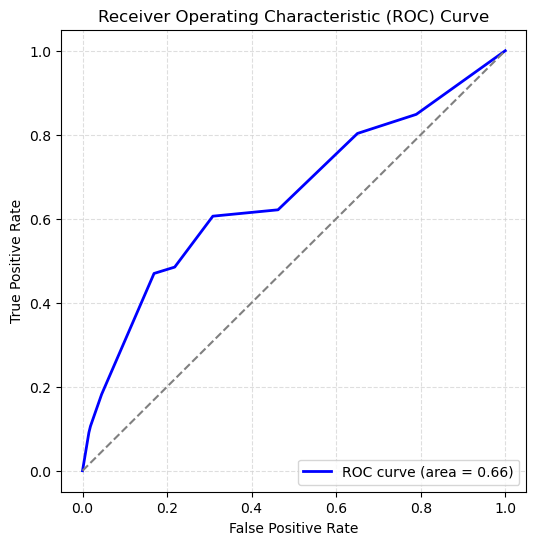

In [93]:
# Step 2: Init the Model
knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15))
])

# Do Machine Learning
doClassification(knn, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[780  20]
 [101  95]]
    
    AUC: 0.9048022959183674

    Classification Report:
                  precision    recall  f1-score   support

           0       0.89      0.97      0.93       800
           1       0.83      0.48      0.61       196

    accuracy                           0.88       996
   macro avg       0.86      0.73      0.77       996
weighted avg       0.87      0.88      0.87       996

    
TEST METRICS
    Confusion Matrix: 
    [[238  28]
 [ 39  27]]
    
    AUC: 0.7913818637502847

    Classification Report:
                  precision    recall  f1-score   support

           0       0.86      0.89      0.88       266
           1       0.49      0.41      0.45        66

    accuracy                           0.80       332
   macro avg       0.68      0.65      0.66       332
weighted avg       0.79      0.80      0.79       332

    


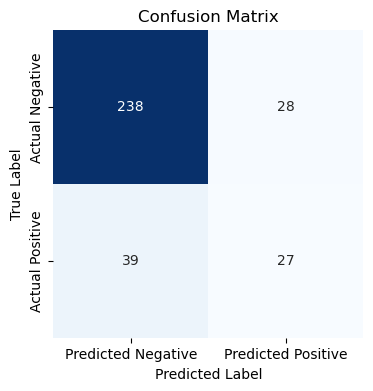

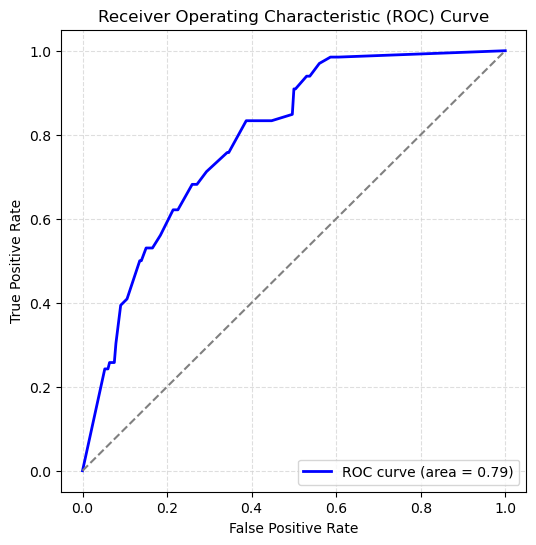

In [94]:
# Step 2: Init the Model
et = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

# Do Machine Learning
doClassification(et, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[793   7]
 [178  18]]
    
    AUC: 0.7051945153061224

    Classification Report:
                  precision    recall  f1-score   support

           0       0.82      0.99      0.90       800
           1       0.72      0.09      0.16       196

    accuracy                           0.81       996
   macro avg       0.77      0.54      0.53       996
weighted avg       0.80      0.81      0.75       996

    
TEST METRICS
    Confusion Matrix: 
    [[264   2]
 [ 66   0]]
    
    AUC: 0.6927261335156071

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      0.99      0.89       266
           1       0.00      0.00      0.00        66

    accuracy                           0.80       332
   macro avg       0.40      0.50      0.44       332
weighted avg       0.64      0.80      0.71       332

    


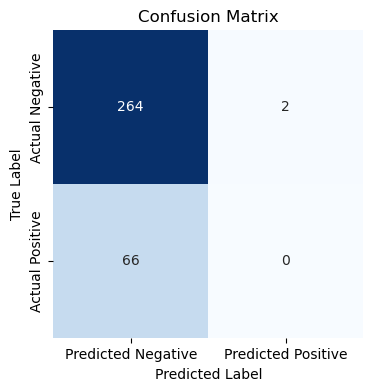

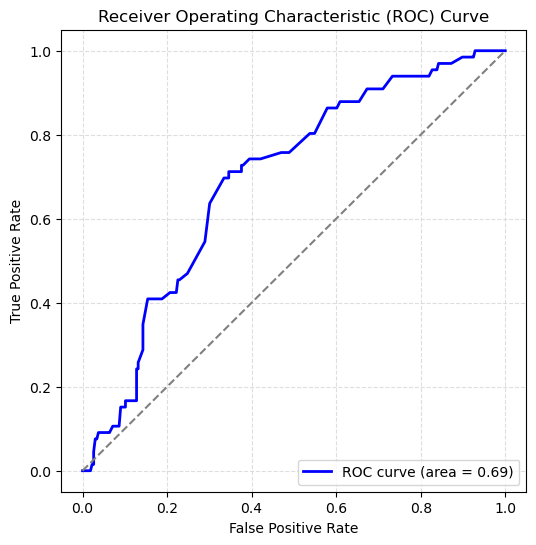

In [95]:
# Step 2: Init the Model
ada = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Do Machine Learning
doClassification(ada, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[791   9]
 [147  49]]
    
    AUC: 0.806498724489796

    Classification Report:
                  precision    recall  f1-score   support

           0       0.84      0.99      0.91       800
           1       0.84      0.25      0.39       196

    accuracy                           0.84       996
   macro avg       0.84      0.62      0.65       996
weighted avg       0.84      0.84      0.81       996

    
TEST METRICS
    Confusion Matrix: 
    [[254  12]
 [ 58   8]]
    
    AUC: 0.7550979722032354

    Classification Report:
                  precision    recall  f1-score   support

           0       0.81      0.95      0.88       266
           1       0.40      0.12      0.19        66

    accuracy                           0.79       332
   macro avg       0.61      0.54      0.53       332
weighted avg       0.73      0.79      0.74       332

    


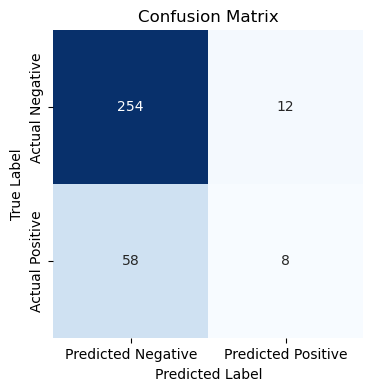

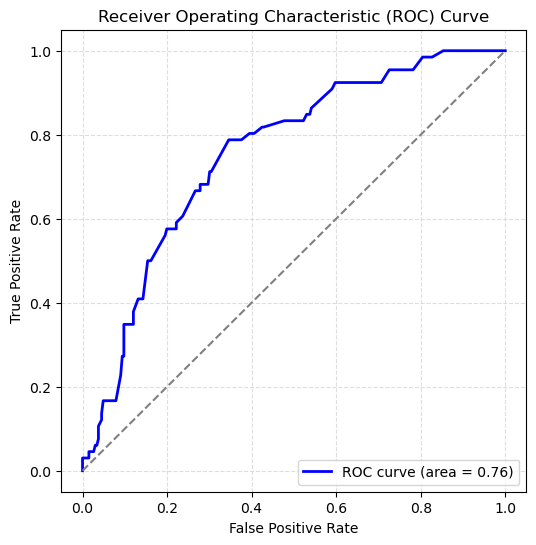

In [96]:
# Step 2: Init the Model
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Do Machine Learning
doClassification(gb, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[774  26]
 [ 98  98]]
    
    AUC: 0.8929432397959183

    Classification Report:
                  precision    recall  f1-score   support

           0       0.89      0.97      0.93       800
           1       0.79      0.50      0.61       196

    accuracy                           0.88       996
   macro avg       0.84      0.73      0.77       996
weighted avg       0.87      0.88      0.86       996

    
TEST METRICS
    Confusion Matrix: 
    [[237  29]
 [ 35  31]]
    
    AUC: 0.7961665527455001

    Classification Report:
                  precision    recall  f1-score   support

           0       0.87      0.89      0.88       266
           1       0.52      0.47      0.49        66

    accuracy                           0.81       332
   macro avg       0.69      0.68      0.69       332
weighted avg       0.80      0.81      0.80       332

    


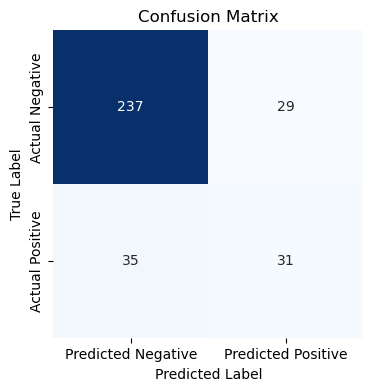

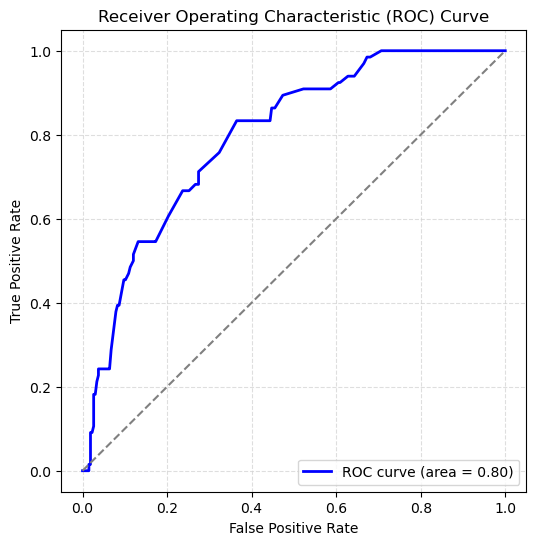

In [97]:
# Step 2: Init the Model
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Do Machine Learning
doClassification(xgb, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[775  25]
 [109  87]]
    
    AUC: 0.8664126275510204

    Classification Report:
                  precision    recall  f1-score   support

           0       0.88      0.97      0.92       800
           1       0.78      0.44      0.56       196

    accuracy                           0.87       996
   macro avg       0.83      0.71      0.74       996
weighted avg       0.86      0.87      0.85       996

    
TEST METRICS
    Confusion Matrix: 
    [[242  24]
 [ 37  29]]
    
    AUC: 0.7809011164274322

    Classification Report:
                  precision    recall  f1-score   support

           0       0.87      0.91      0.89       266
           1       0.55      0.44      0.49        66

    accuracy                           0.82       332
   macro avg       0.71      0.67      0.69       332
weighted avg       0.80      0.82      0.81       332

    


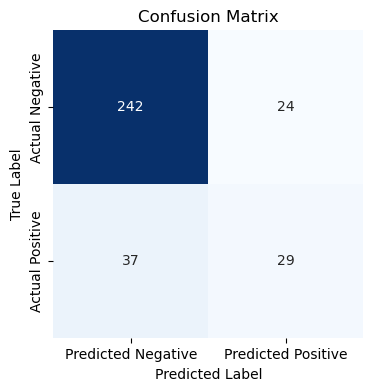

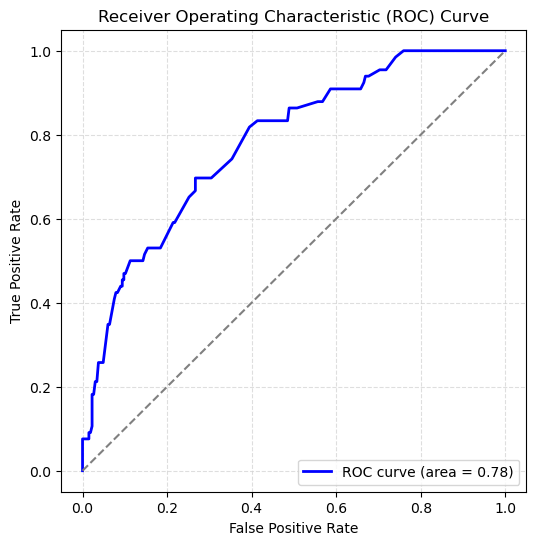

In [98]:
# Step 2: Init the Model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1))
])

# Do Machine Learning
doClassification(lgbm, X_train, X_test, y_train, y_test)

In [99]:
fi = pd.DataFrame(list(zip(X.columns, gb.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,Model Year,0.289899
5,Clear,0.102419
10,Speed Category,0.064911
6,Snow,0.041736
3,Roadway Surface,0.041010
7,Cloudy,0.036854
1,Time of Day,0.034347
9,Passengers Belted,0.026420
8,Rain,0.023193
4,Speed Limit,0.012818


In [100]:
fi = pd.DataFrame(list(zip(X.columns, xgb.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
4,Speed Limit,0.283460
5,Clear,0.063731
6,Snow,0.054055
1,Time of Day,0.048721
8,Rain,0.045853
0,Model Year,0.042716
10,Speed Category,0.035030
9,Passengers Belted,0.032977
7,Cloudy,0.032315
3,Roadway Surface,0.023073


In [101]:
fi = pd.DataFrame(list(zip(X.columns, lgbm.named_steps['classifier'].feature_importances_ / sum(lgbm.named_steps['classifier'].feature_importances_))), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,Model Year,0.341463
10,Speed Category,0.118723
6,Snow,0.083572
5,Clear,0.080703
8,Rain,0.062052
7,Cloudy,0.059541
1,Time of Day,0.024032
9,Passengers Belted,0.021879
3,Roadway Surface,0.020803
4,Speed Limit,0.000359


In [102]:
fi = pd.DataFrame(list(zip(X.columns, ada.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,Model Year,0.66
10,Speed Category,0.06
1,Time of Day,0.04
5,Clear,0.04
3,Roadway Surface,0.02
4,Speed Limit,0.02
6,Snow,0.02
7,Cloudy,0.02
2,Roadway Type,0.00
8,Rain,0.00


In [103]:
# Create a pipeline with a scaler and a logistic regression model
lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lr, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {np.mean(cv_scores):.3f}")

Cross-validation AUC scores: [0.62857649 0.52865621 0.61587886 0.66869809 0.3698086 ]
Mean AUC: 0.562


In [104]:
# Create a pipeline with a scaler and a logistic regression model
ada = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(ada, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {np.mean(cv_scores):.3f}")

Cross-validation AUC scores: [0.51155993 0.61608646 0.67712078 0.72332069 0.43743229]
Mean AUC: 0.593


In [105]:
# Create a pipeline with a scaler and a logistic regression model
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(gb, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {np.mean(cv_scores):.3f}")

Cross-validation AUC scores: [0.53574276 0.58127381 0.67833393 0.69560311 0.40682557]
Mean AUC: 0.580


In [106]:
# Create a pipeline with a scaler and a logistic regression model
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(xgb, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {np.mean(cv_scores):.3f}")

Cross-validation AUC scores: [0.56320312 0.5681637  0.55036844 0.70408992 0.50966053]
Mean AUC: 0.579


In [107]:
# Create a pipeline with a scaler and a logistic regression model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {np.mean(cv_scores):.3f}")

Cross-validation AUC scores: [0.53875454 0.58924617 0.54668404 0.72214698 0.51914048]
Mean AUC: 0.583


In [108]:
# Retrain the model on the ENTIRE dataset
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])
lgbm.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Model Year']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(missing_values=<NA>,
                                                                                 strategy='most_frequent')),
                                                                  ('label',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Clear', 'Snow', 'Cloudy',
                                                   'Rain',
                                                   'Passengers Belted']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(missing_values=<NA>,
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Time of Day',
                                                   'Roadway Type',
                                                   'Roadway Surface',
                                                   'Speed Category'])])),
                ('classifier', LGBMClassifier(random_state=42, verbose=-1))])

In [109]:
# Save off my models
import pickle

# Model
pickle.dump(xgb, open("car_crash_ml.h5", 'wb'))